In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import skimage.feature
import sklearn.metrics

## Load Data and Data Pre-Processing for Models

In [2]:
## Load the data 
train_images = np.load('trnImage.npy')
train_labels = np.load('trnLabel.npy')
test_images =np.load('tstImage.npy')
test_labels=np.load('tstLabel.npy')

# NOTE: data is already split into test and train

In [3]:
## Data pre-processing:

#transpose the data
'''
REASON: 
file is currently in 4D array of h x w x RGB x img
but the model takes in image and THEN the dimension
(i.e. img x h x w x RGB),
so we need to reshape the data for input. 
This is one way of doing it:
'''
train_transposed = np.transpose(train_images, (3,0,1,2))
test_transposed = np.transpose(test_images, (3,0,1,2))

#convert decimal label values (0-9) to their binary representations to make it easier for the model to understand 
vectorise_train_labels = tf.keras.utils.to_categorical(train_labels)
vectorise_test_labels = tf.keras.utils.to_categorical(test_labels)


In [4]:
## Specify features for the SVM model to look at

# initialise 2D arrays to hold extracted features of each image from their respective datasets
train_img_features = np.zeros([10000,324]) 
test_img_features = np.zeros([1000,324])

#Extract HOG features
def extract_HOG_Features(image):
    hog_feature = skimage.feature.hog(image)
    return hog_feature #returns 1D array of 324 features

# populate the training arrays with the extracted hog features
for i in range (0, 10000):
    features = extract_HOG_Features(train_transposed[i,:,:,:])
    train_img_features[i,:] = features

# populate the testing arrays with the extracted hog features    
for i in range (0, 1000):
    features = extract_HOG_Features(test_transposed[i,:,:,:])
    test_img_features[i,:] = features

## Proposed Solution: CNN

In [7]:
# Define the model
model = tf.keras.Sequential(layers=[
    tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu,padding='same', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, [3,3], activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, [3,3], activation=tf.nn.relu),
    tf.keras.layers.Conv2D(128, [3,3], activation=tf.nn.relu),
    tf.keras.layers.Conv2D(256, [3,3], activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),    
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy(name="accuracy"))

history = model.fit(train_transposed, vectorise_train_labels, validation_data=(test_transposed , vectorise_test_labels),epochs=100, batch_size =64)


Epoch 1/100
157/157 [==============================] - 2s 14ms/step - loss: 2.0890 - accuracy: 0.1994 - val_loss: 1.9104 - val_accuracy: 0.2920
Epoch 2/100
157/157 [==============================] - 1s 9ms/step - loss: 1.7899 - accuracy: 0.3227 - val_loss: 1.8312 - val_accuracy: 0.3310
Epoch 3/100
157/157 [==============================] - 1s 9ms/step - loss: 1.6220 - accuracy: 0.3951 - val_loss: 1.6128 - val_accuracy: 0.4000
Epoch 4/100
157/157 [==============================] - 1s 9ms/step - loss: 1.5052 - accuracy: 0.4506 - val_loss: 1.4995 - val_accuracy: 0.4430
Epoch 5/100
157/157 [==============================] - 1s 9ms/step - loss: 1.3971 - accuracy: 0.4917 - val_loss: 1.4795 - val_accuracy: 0.4730
Epoch 6/100
157/157 [==============================] - 1s 9ms/step - loss: 1.3172 - accuracy: 0.5221 - val_loss: 1.3291 - val_accuracy: 0.5220
Epoch 7/100
157/157 [==============================] - 1s 9ms/step - loss: 1.2343 - accuracy: 0.5531 - val_loss: 1.3042 - val_accuracy: 0.561

In [9]:
# Test model
results = model.evaluate(test_transposed,vectorise_test_labels)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

32/32 [==============================] - 0s 9ms/step - loss: 6.0327 - accuracy: 0.6190
Test set loss: 6.03, test set accuracy: 61.90%


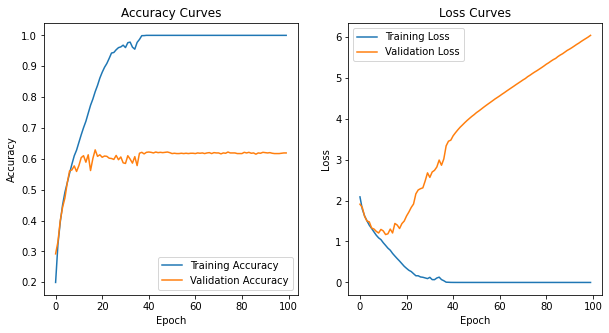

In [8]:
# Visualise the Accuracy Curve
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

#Visualise lost data within the model
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


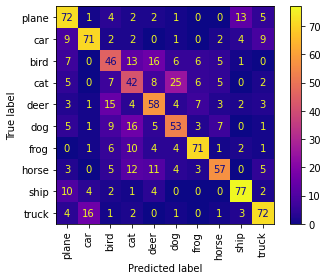

In [10]:
# Make prediction of data
y_val= model.predict(test_transposed)
# Predict classes for test data
rounded_y_val =model.predict_classes(test_transposed)

# Calculate confusion matrix
cm_cnn = sklearn.metrics.confusion_matrix(test_labels,rounded_y_val)

categories = ['plane', 'car', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']


# Visualise confusion matrix
plot_cm_cnn = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=categories)
plot_cm_cnn.plot(cmap=plt.cm.plasma,values_format='g', xticks_rotation='vertical', include_values=True)




## Comparative Classification Method: SVM

In [5]:
## SVM Model Code

# Standardise values in the datasets by centering and scaling
scaler = StandardScaler()
scaler.fit(train_img_features)
train_img_features = scaler.transform(train_img_features)
test_img_features = scaler.transform(test_img_features)

# Initialise and train SVM model 
models = SVC(kernel='rbf')
models.fit(train_img_features, train_labels.ravel())

# predict the labels
y_pred = models.predict(test_img_features)

# report accuracy of model against test data and labels
score = models.score(test_img_features, test_labels.ravel())
print("Score: ", score * 100, "%")

Score:  60.0 %


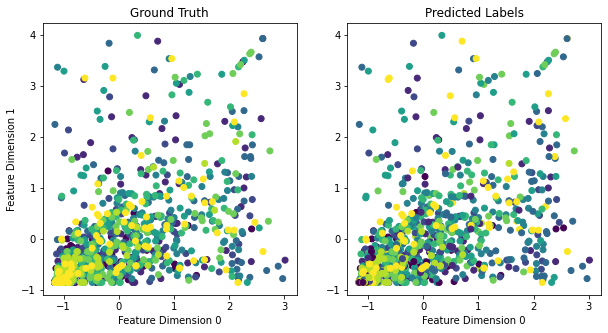

In [5]:
# Visualise actual data
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.scatter(test_img_features[:,0], test_img_features[:,1],c=test_labels.ravel())
plt.ylabel('Feature Dimension 1')
plt.xlabel('Feature Dimension 0')
plt.title('Ground Truth')

#Visualise predictions
plt.subplot(122)
plt.title('Predicted Labels')
plt.xlabel('Feature Dimension 0')
prediction = models.predict(test_img_features)
plt.scatter(test_img_features[:,0], test_img_features[:,1], c=prediction)
plt.show()

# calculate the confusion matrix 
cm_svm = sklearn.metrics.confusion_matrix(test_labels, y_pred)

# define 10 categories of objects
categories = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

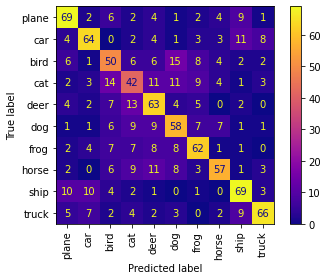

In [6]:
# Visualise the confusion matrix
plot_cm = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_svm,display_labels=categories)
plot_cm.plot(cmap=plt.cm.plasma,values_format='g',xticks_rotation='vertical',include_values=True)